In [1]:
import matplotlib.pyplot as plt
from numpy.random import default_rng
import numpy as np
import torch

from utils import split_data_gnn, train, get_batch_dimensions
import torch.nn.functional as F
from torch import nn
from torch.utils.data import  DataLoader
from IPython.display import clear_output
import numpy as np
import mdtraj as md

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# check if a GPU is available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

### Load MD data

In [4]:
positions = torch.load('positions.pt')
potential_energies = torch.load('e_pot.pt')
forces = torch.load('forces.pt')

n_samples = potential_energies.shape[0]
positions.shape, potential_energies.shape

(torch.Size([10000, 4, 3]), torch.Size([10000, 1]))

In [5]:
n_particles = positions.shape[-2]
n_particles

4

In [6]:
atomic_numbers = torch.ones(( n_samples, n_particles,1))

In [7]:
all_data,train_data,test_data = split_data_gnn(positions, potential_energies,forces,atomic_numbers, train_fraction=.9, device=DEVICE)


Note that we reshaped the positions from (n_samples, n_particles, 3) to (n_samples*n_particles, 3)   because the PyTorch Geometric library expects it this way.

In [8]:
train_data.positions.shape

torch.Size([9000, 4, 3])

## Model

Load your own model if you have implemented one in Exercise 10!

In [9]:
from schnet_solution import SchNet
# import sys
# sys.path.append(f"/home/psireal42/study/ml-mol-physics")
# from UB10.schnet import Schnet

In [12]:
schnet_net = SchNet(
            hidden_channels=32,
            num_filters=32,
            num_interactions=2,
            num_gaussians=10,
            cutoff=10.0,
        )

This is how we get energy predictions from the model for a batch of samples.

In [10]:
n_samples = 10
batch_dimensions = get_batch_dimensions(n_samples, n_particles)

In [13]:
predictions = schnet_net(
    train_data.atomic_numbers[:n_samples].reshape(-1, 1),
    train_data.positions[:n_samples].reshape(-1, 3),
    batch_dimensions,
)
predictions.shape

torch.Size([10, 1])

In [12]:
trainloader = DataLoader(train_data,batch_size=64,shuffle=True)


In [15]:
# criterion to computes the loss between input and target
criterion = nn.MSELoss()

# optimizer that will be used to update weights and biases
optim = torch.optim.Adam(schnet_net.parameters(),lr=1e-3)

## 1.3 Training on energy and forces

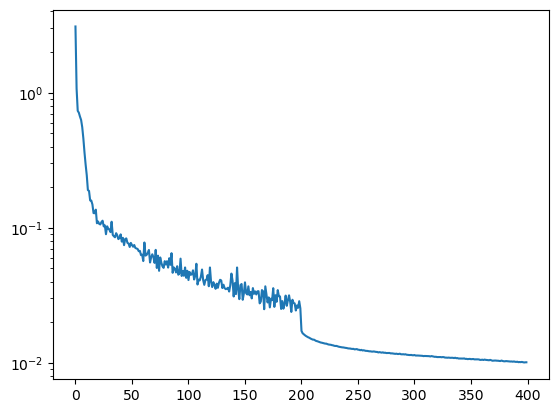

100%|██████████| 400/400 [23:00<00:00,  3.45s/it]


In [13]:
from tqdm import trange

# Train model with energy-only training 
schnet_net_ene = SchNet(
            hidden_channels=32,
            num_filters=32,
            num_interactions=2,
            num_gaussians=10,
            cutoff=10.0,
        )

n_epochs = 400
optim = torch.optim.Adam(schnet_net_ene.parameters(),lr=1e-3)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optim,
                                                 milestones=[200,200],
                                                 gamma=1e-1)

# criterion to computes the loss between input and target
criterion = nn.MSELoss()

# optimizer that will be used to update weights and biases

losses = []
for _ in trange(n_epochs):
    loss = train(model = schnet_net_ene,
                 train_loader = trainloader,
                 optimizer = optim,
                 criterion = criterion,
                 rho_ene=0,
                 rho_force=1,
                 device = DEVICE)
    
    losses.append(loss)
    clear_output(wait=True)

    plt.plot(losses)
    plt.yscale('log')
    plt.show()
    
    scheduler.step()

In [17]:
results = {'losses': losses,
           'state': schnet_net_ene.state_dict()}
model_name = "model_without_force"

with open(model_name + '.torch', 'wb') as f:
    torch.save(results, f)

For the trained models, compute the predictions for forces and energies (for the test set) and
compare with the true values in a true-vs-predicted plot and report the MSEs. Briefly comment
on your results.

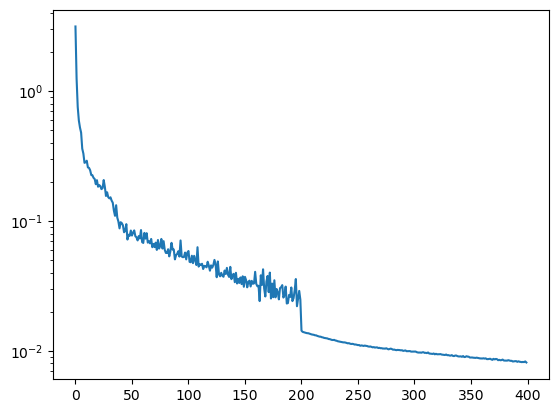

100%|██████████| 400/400 [23:51<00:00,  3.58s/it]


In [15]:
from tqdm import trange

# Train model with force-only training 
schnet_net_force = SchNet(
            hidden_channels=32,
            num_filters=32,
            num_interactions=2,
            num_gaussians=10,
            cutoff=10.0,
        )

n_epochs = 400

optim = torch.optim.Adam(schnet_net_force.parameters(),lr=1e-3)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optim,
                                                 milestones=[200,200],
                                                 gamma=1e-1)
losses = []
for _ in trange(n_epochs):
    loss = train(model = schnet_net_force,
                 train_loader = trainloader,
                 optimizer = optim,
                 criterion = criterion,
                 rho_ene=0,
                 rho_force=1,
                 device = DEVICE)
    
    losses.append(loss)
    clear_output(wait=True)

    plt.plot(losses)
    plt.yscale('log')
    plt.show()
    
    scheduler.step()

In [16]:
results = {'losses': losses,
           'state': schnet_net_force.state_dict()}
model_name = "model_without_energy"

with open(model_name + '.torch', 'wb') as f:
    torch.save(results, f)

For the trained models, compute the predictions for forces and energies (for the test set) and
compare with the true values in a true-vs-predicted plot and report the MSEs. Briefly comment
on your results.

MSE for energies: 62.32642364501953


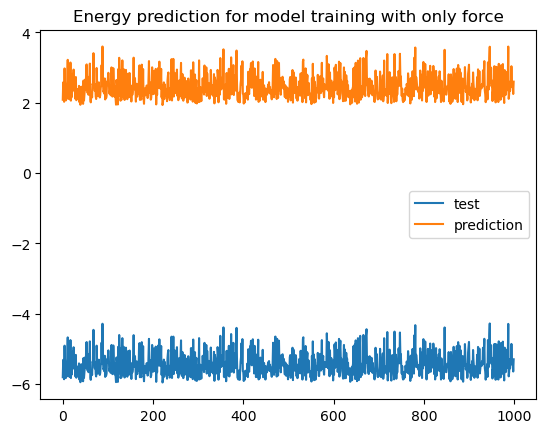

In [18]:
from schnet_solution import SchNet


model_name = "model_without_energy"
schnet_net_force = SchNet(
            hidden_channels=32,
            num_filters=32,
            num_interactions=2,
            num_gaussians=10,
            cutoff=10.0,
        )
schnet_net_force.load_state_dict(torch.load(model_name + '.torch', map_location=DEVICE)['state'])

n_samples = 1000
batch_dimensions = get_batch_dimensions(n_samples, n_particles)
energies_predictions = schnet_net_force(
    test_data.atomic_numbers[:n_samples].reshape(-1, 1),
    test_data.positions[:n_samples].reshape(-1, 3),
    batch_dimensions,
)

from torchmetrics.functional import mean_squared_error

plt.figure()
plt.plot(test_data.energies, label="test")
plt.plot(energies_predictions.detach().numpy(), label="prediction")
plt.legend()
plt.title("Energy prediction for model training with only force")

mse_test = mean_squared_error(test_data.energies, energies_predictions)
print(f"MSE for energies: {mse_test}")



MSE for energies: 133.49407958984375


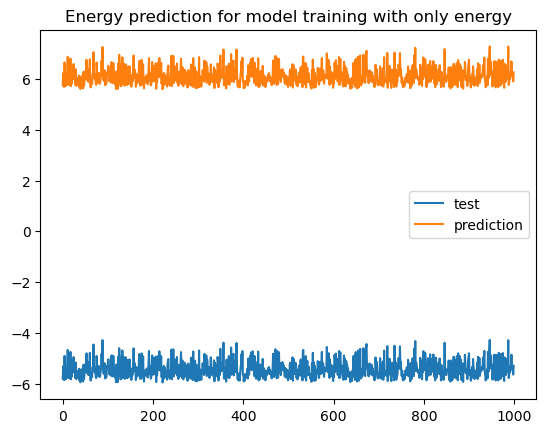

In [19]:
model_name = "model_without_force"
schnet_net_ene = SchNet(
            hidden_channels=32,
            num_filters=32,
            num_interactions=2,
            num_gaussians=10,
            cutoff=10.0,
        )
schnet_net_ene.load_state_dict(torch.load(model_name + '.torch', map_location=DEVICE)['state'])

n_samples = 1000
batch_dimensions = get_batch_dimensions(n_samples, n_particles)
energies_predictions = schnet_net_ene(
    test_data.atomic_numbers[:n_samples].reshape(-1, 1),
    test_data.positions[:n_samples].reshape(-1, 3),
    batch_dimensions,
)

from torchmetrics.functional import mean_squared_error

plt.figure()
plt.plot(test_data.energies, label="test")
plt.plot(energies_predictions.detach().numpy(), label="prediction")
plt.legend()
plt.title("Energy prediction for model training with only energy")

mse_test = mean_squared_error(test_data.energies, energies_predictions)
print(f"MSE for energies: {mse_test}")


Not so sure why the predictions are both so bad...

## 1.4 Running molecular dynamics

In [20]:
def energy_model(model: nn.Module, 
                 r: torch.Tensor, 
                 z: torch.Tensor,
                 n_particles: int,
                 batch_size: int = 1 ):
    
    batch_dimensions = get_batch_dimensions(batch_size=batch_size, n_particles=n_particles)
    r_cloned = torch.clone(r) 
    z_reshaped = z[:batch_size].reshape(-1, 1)

    # obtain energy prediction from model
    energies = model(z_reshaped, r_cloned, batch_dimensions) # shape = (batch_size, 1)

    return energies

In [21]:
potential_energies = torch.load('e_pot.pt')
E_pot = potential_energies.numpy().reshape(-1)
np.abs(E_pot - np.mean(E_pot)).argmin()
print(f"Index of configuration with energy close to the mean energy: {np.abs(E_pot - np.mean(E_pot)).argmin()}")

Index of configuration with energy close to the mean energy: 5286


In [22]:
from utils import get_forces, langevin_step, energy_lj, assign_MBv, e_kin
d = 1.1

# 3d cluster with 4 particles
positions = torch.load('positions.pt')
clus3d = positions[5286]

# compute LJ energy
atomic_numbers = torch.ones(( 1, n_particles,1))
energy = energy_model(model=schnet_net_ene,
                      r=clus3d,
                      z=atomic_numbers,
                      n_particles=n_particles)
# set Boltzmann constant
beta = 8.
m = 1.0
dt =1e-3
r = torch.clone(clus3d)
n_particles = len(r)
n_dimensions = r.shape[-1]

# assign intial MB velocities
v = assign_MBv(n_particles, beta, m)

# compute initial forces
f = get_forces(energy_lj, r)
# initialize number of MD steps
n_steps = 20000

n_log = 10

# energies
potential_energies = torch.empty((n_steps // n_log,1))
kinetic_energies = torch.empty((n_steps // n_log,1))
positions = torch.ones((n_steps // n_log, n_particles, n_dimensions))
forces = torch.empty((n_steps // n_log, n_particles, n_dimensions))
# initialize langevin parameters
lgamma = torch.tensor(1.0)
c1 = torch.exp(-lgamma*dt/2.0)
c2 = torch.sqrt((1.0-(c1*c1))/beta)
lc = torch.tensor([c1,c2])
from tqdm import trange, tqdm

for i in trange(n_steps):
    if i % n_log == 0:
        positions[i // n_log] = r
        potential_energies[i// n_log] = energy_model(model=schnet_net_ene,
                                                     r=r,
                                                     z=atomic_numbers,
                                                     n_particles=n_particles)
        kinetic_energies[i// n_log] = e_kin(v)
        forces[i// n_log] = f

    r, v, f = langevin_step(r, v, f,energy_lj, dt, lc)



  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [00:07<00:00, 2799.19it/s]


(array([0.145866  , 0.34643176, 0.54699751, 0.45583126, 0.98459552,
        1.27630534, 1.02106203, 0.85696277, 1.20339453, 1.20339453,
        1.54982629, 1.51335979, 1.53159304, 2.04212405, 1.38570294,
        1.22162778, 1.05752853, 1.22162778, 0.98459552, 1.07576178,
        0.96636227, 1.00282877, 0.67463027, 0.87519602, 0.76579652,
        0.74755027, 0.74756327, 1.00282877, 0.58346401, 0.61993052,
        0.85696277, 0.76579652, 0.83872952, 0.54699751, 0.6016868 ,
        0.25526551, 0.36466501, 0.41936476, 0.45583126, 0.27349876,
        0.25526551, 0.25526551, 0.41936476, 0.09116625, 0.1093995 ,
        0.12763053, 0.05469975, 0.0364665 , 0.0364665 , 0.09116625]),
 array([5.57764864, 5.60507107, 5.6324935 , 5.65991592, 5.68733835,
        5.71476078, 5.74218369, 5.76960611, 5.79702854, 5.82445097,
        5.8518734 , 5.87929583, 5.90671825, 5.93414068, 5.96156311,
        5.98898602, 6.01640844, 6.04383087, 6.0712533 , 6.09867573,
        6.12609816, 6.15352058, 6.18094301, 6.

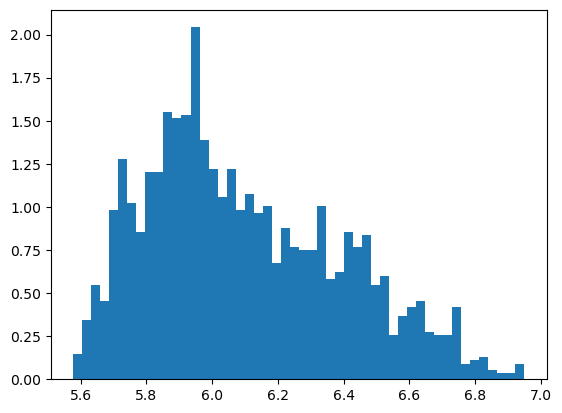

In [23]:
plt.hist(potential_energies.detach().numpy(), bins=50, density=True)

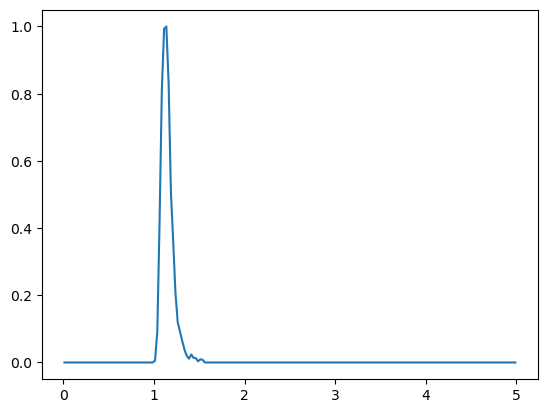

In [24]:
from utils import radial_distribution_function

rdf = radial_distribution_function(positions.detach().numpy())
plt.plot(rdf[0], rdf[1] / rdf[1].max())

In [25]:
from utils import get_forces, langevin_step, energy_lj, assign_MBv, e_kin
d = 1.1

# 3d cluster with 4 particles
positions = torch.load('positions.pt')
clus3d = positions[5286]

# compute LJ energy
atomic_numbers = torch.ones(( 1, n_particles,1))
energy = energy_model(model=schnet_net_force,
                      r=clus3d,
                      z=atomic_numbers,
                      n_particles=n_particles)
# set Boltzmann constant
beta = 8.
m = 1.0
dt =1e-3
r = torch.clone(clus3d)
n_particles = len(r)
n_dimensions = r.shape[-1]

# assign intial MB velocities
v = assign_MBv(n_particles, beta, m)

# compute initial forces
f = get_forces(energy_lj, r)
# initialize number of MD steps
n_steps = 20000

n_log = 10

# energies
potential_energies = torch.empty((n_steps // n_log,1))
kinetic_energies = torch.empty((n_steps // n_log,1))
positions = torch.ones((n_steps // n_log, n_particles, n_dimensions))
forces = torch.empty((n_steps // n_log, n_particles, n_dimensions))
# initialize langevin parameters
lgamma = torch.tensor(1.0)
c1 = torch.exp(-lgamma*dt/2.0)
c2 = torch.sqrt((1.0-(c1*c1))/beta)
lc = torch.tensor([c1,c2])
from tqdm import trange, tqdm

for i in trange(n_steps):
    if i % n_log == 0:
        positions[i // n_log] = r
        potential_energies[i// n_log] = energy_model(model=schnet_net_force,
                                                     r=r,
                                                     z=atomic_numbers,
                                                     n_particles=n_particles)
        kinetic_energies[i// n_log] = e_kin(v)
        forces[i// n_log] = f

    r, v, f = langevin_step(r, v, f,energy_lj, dt, lc)



100%|██████████| 20000/20000 [00:06<00:00, 3033.43it/s]


(array([0.09746074, 0.2436509 , 0.71471207, 0.86089984, 1.00709037,
        1.283238  , 1.23449788, 1.68931289, 1.72181301, 1.52687895,
        1.78677324, 1.93296378, 1.60810838, 1.78677324, 1.34820163,
        1.10455073, 1.38069911, 1.4294186 , 1.15328091, 0.90963706,
        1.21825448, 0.79592626, 0.55227537, 0.53603613, 0.4710584 ,
        0.50354519, 0.40608797, 0.2274075 , 0.30862447, 0.25989429,
        0.24365278, 0.45481501, 0.38984144, 0.24365278, 0.17867732,
        0.19492072, 0.04873018, 0.09746111, 0.12994715, 0.01624339,
        0.04873018, 0.01624352, 0.04873018, 0.01624339, 0.04873056,
        0.04873018, 0.09746036, 0.        , 0.03248704, 0.03248679]),
 array([1.91829562, 1.94907725, 1.97985899, 2.01064062, 2.04142237,
        2.07220411, 2.10298562, 2.13376737, 2.16454911, 2.19533062,
        2.22611237, 2.25689411, 2.28767586, 2.31845737, 2.34923911,
        2.38002086, 2.4108026 , 2.44158411, 2.47236586, 2.5031476 ,
        2.53392911, 2.56471086, 2.5954926 , 2.

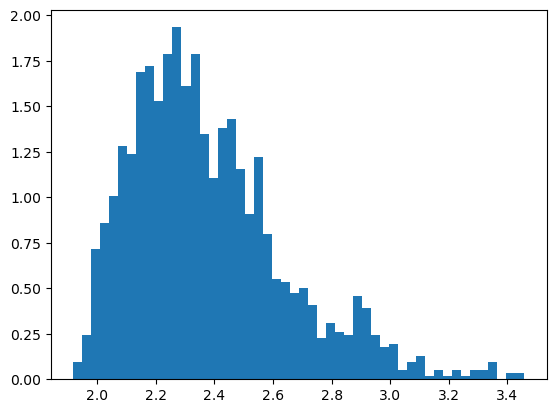

In [26]:
plt.hist(potential_energies.detach().numpy(), bins=50, density=True)

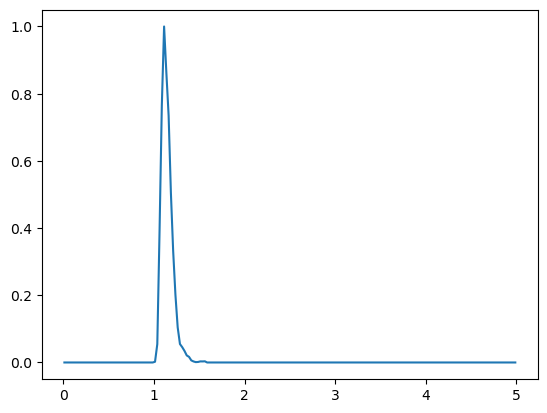

In [27]:
from utils import radial_distribution_function

rdf = radial_distribution_function(positions.detach().numpy())
plt.plot(rdf[0], rdf[1] / rdf[1].max())

shift of energy if use model trained with force due to integral constant.